# Numerical Optimization

Reference: [Numerical Optimization by Nocedal and Wright](http://www.springer.com/us/book/9780387303031)

## Categorize your optimization problem

Different optimization problems require different classes of optimization algorithms for efficient solution. Some fundamental decision points: The tree below can serve as a guide for which class of optimization algorithm is appropriate.

![Optimization Tree](https://neos-guide.org/sites/default/files/graphviz/dcd8800d05552f6159a3dc0a0b2bdb38.out.svg)

We will mainly discuss the optimization of smooth functions, with and without constraints.

# Using optimization routines from `scipy` and `statsmodels`

In [6]:
%matplotlib inline

In [7]:
import scipy.linalg as la
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
np.set_printoptions(precision=3, suppress=True)

Using `scipy.optimize`
----

One of the most convenient libraries to use is `scipy.optimize`, since it is already part of the Anaconda installation and it has a fairly intuitive interface.

In [9]:
from scipy import optimize as opt

#### Minimizing a univariate function $f: \mathbb{R} \rightarrow \mathbb{R}$

In [10]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

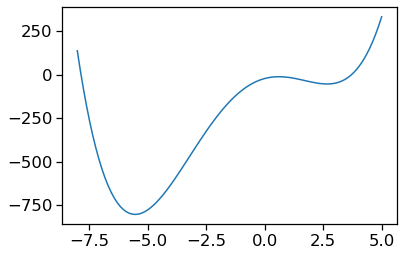

In [11]:
x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));

The [`minimize_scalar`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar) function will find the minimum, and can also be told to search within given bounds. By default, it uses the Brent algorithm, which combines a bracketing strategy with a parabolic approximation.

In [12]:
opt.minimize_scalar(f, method='Brent')

     fun: -803.3955308825884
    nfev: 17
     nit: 11
 success: True
       x: -5.528801125219663

In [13]:
opt.minimize_scalar(f, method='bounded', bounds=[0, 6])

     fun: -54.21003937712762
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 2.668865104039653

### Local and global minima

In [14]:
def f(x, offset):
    return -np.sinc(x-offset)

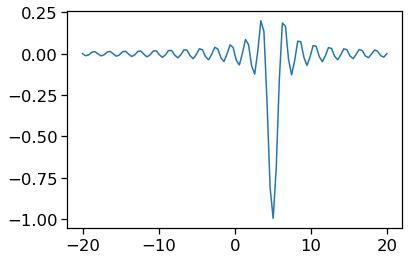

In [15]:
x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5));

In [16]:
# note how additional function arguments are passed in
sol = opt.minimize_scalar(f, args=(5,))
sol

     fun: -0.049029624014074166
    nfev: 15
     nit: 10
 success: True
       x: -1.4843871263953001

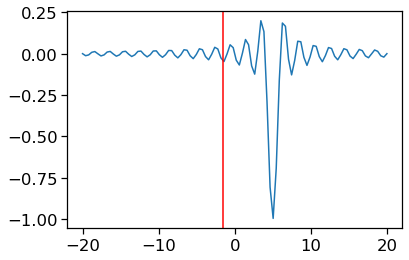

In [17]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red')
pass

#### We can try multiple random starts to find the global minimum

In [18]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
sols = [opt.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

In [19]:
idx = np.argmin([sol.fun for sol in sols])
sol = sols[idx]

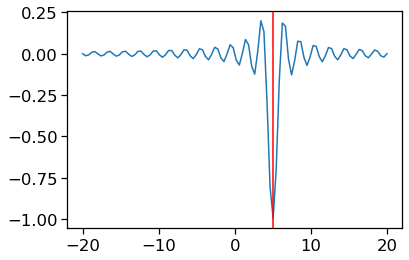

In [20]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

#### Using a stochastic algorithm

See documentation for the [`basinhopping`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.basinhopping.html) algorithm, which also works with multivariate scalar optimization. Note that this is heuristic and not guaranteed to find a global minimum.

In [21]:
from scipy.optimize import basinhopping

x0 = 0
sol = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)})
sol

                        fun: -1.0
 lowest_optimization_result:       fun: -1.0
 hess_inv: array([[0.304]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([5.])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1710
                        nit: 100
                       njev: 570
                          x: array([5.])

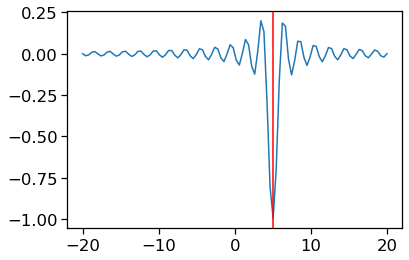

In [22]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

### Constrained optimization with `scipy.optimize`

Many real-world optimization problems have constraints - for example, a set of parameters may have to sum to 1.0 (equality constraint), or some parameters may have to be non-negative (inequality constraint). Sometimes, the constraints can be incorporated into the function to be minimized, for example, the non-negativity constraint $p \gt 0$ can be removed by substituting $p = e^q$ and optimizing for $q$. Using such workarounds, it may be possible to convert a constrained optimization problem into an unconstrained one, and use the methods discussed above to solve the problem.

Alternatively, we can use optimization methods that allow the specification of constraints directly in the problem statement as shown in this section. Internally, constraint violation penalties, barriers and Lagrange multipliers are some of the methods used used to handle these constraints. We use the example provided in the Scipy [tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html) to illustrate how to set constraints.

We will optimize:

$$
f(x) = -(2xy + 2x - x^2 -2y^2)
$$
subject to the constraint
$$
x^3 - y = 0 \\
y - (x-1)^4 - 2 \ge 0
$$
and the bounds
$$
0.5 \le x \le 1.5 \\
1.5 \le y \le 2.5
$$

In [23]:
def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

[0, 3, 0, 3]

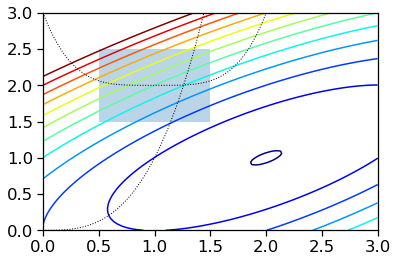

In [24]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1), cmap='jet');
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3])

To set constraints, we pass in a dictionary with keys `type`, `fun` and `jac`. Note that the inequality constraint assumes a $C_j x \ge 0$ form. As usual, the `jac` is optional and will be numerically estimated if not provided.

In [25]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0]**3 - x[1]]),
         'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
        {'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - (x[0]-1)**4 - 2])})

bnds = ((0.5, 1.5), (1.5, 2.5))

In [26]:
x0 = [0, 2.5]

Unconstrained optimization

In [27]:
ux = opt.minimize(f, x0, constraints=None)
ux

      fun: -1.9999999999996365
 hess_inv: array([[0.998, 0.501],
       [0.501, 0.499]])
      jac: array([ 0., -0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([2., 1.])

Constrained optimization

In [28]:
cx = opt.minimize(f, x0, bounds=bnds, constraints=cons)
cx

     fun: 2.049915472024102
     jac: array([-3.487,  5.497])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.261, 2.005])

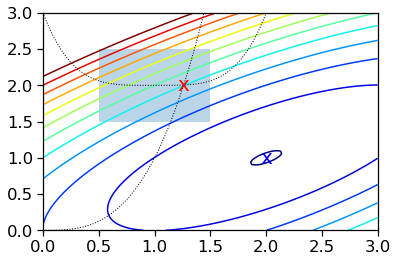

In [29]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1), cmap='jet');
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.text(ux['x'][0], ux['x'][1], 'x', va='center', ha='center', size=20, color='blue')
plt.text(cx['x'][0], cx['x'][1], 'x', va='center', ha='center', size=20, color='red')
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3]);

## Some applications of optimization

### Finding paraemeters for ODE models

This is a specialized application of `curve_fit`, in which the curve to be fitted is defined implicitly by an ordinary differential equation 
$$
\frac{dx}{dt} = -kx
$$
and we want to use observed data to estimate the parameters $k$ and the initial value $x_0$. Of course this can be explicitly solved but the same approach can be used to find multiple parameters for $n$-dimensional systems of ODEs.

[A more elaborate example for fitting a system of ODEs to model the zombie apocalypse](http://adventuresinpython.blogspot.com/2012/08/fitting-differential-equation-system-to.html)

In [33]:
from scipy.integrate import odeint
from scipy.optimize import curve_fit

def f(x, t, k):
    """Simple exponential decay."""
    return -k*x

def x(t, k, x0):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(k,))
    return x.ravel()

In [34]:
# True parameter values
x0_ = 10
k_ = 0.1*np.pi

# Some random data genererated from closed form solution plus Gaussian noise
ts = np.sort(np.random.uniform(0, 10, 200))
xs = x0_*np.exp(-k_*ts) + np.random.normal(0,0.1,200)

popt, cov = curve_fit(x, ts, xs)
k_opt, x0_opt = popt

print("k = %g" % k_opt)
print("x0 = %g" % x0_opt)

k = 0.313873
x0 = 9.87531


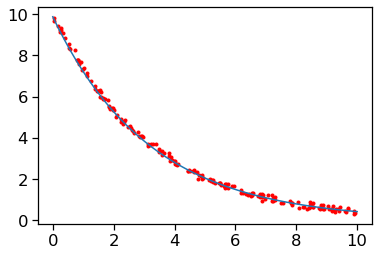

In [35]:
import matplotlib.pyplot as plt
t = np.linspace(0, 10, 100)
plt.plot(ts, xs, 'r.', t, x(t, k_opt, x0_opt), '-');

### Optimization with `sklearn`

There are also many optimization routines in the `scikit-learn` package, as you already know from the previous lectures. Many machine learning problems essentially boil down to the minimization of some appropriate loss function.

### Curve fitting and least squares optimization

As shown above, least squares optimization is the technique most associated with curve fitting. For convenience, `scipy.optimize` provides a `curve_fit` function that uses Levenberg-Marquadt for minimization.

In [1]:
from scipy.optimize import curve_fit 

In [4]:
def logistic4(x, a, b, c, d):
    """The four paramter logistic function is often used to fit dose-response relationships."""
    return ((a-d)/(1.0+((x/c)**b))) + d

In [7]:
nobs = 24
xdata = np.linspace(0.5, 3.5, nobs)
ptrue = [10, 3, 1.5, 12]
ydata = logistic4(xdata, *ptrue) + 0.5*np.random.random(nobs)

In [8]:
popt, pcov = curve_fit(logistic4, xdata, ydata) 

In [9]:
perr = yerr=np.sqrt(np.diag(pcov))
print('Param\tTrue\tEstim (+/- 1 SD)')
for p, pt, po, pe  in zip('abcd', ptrue, popt, perr):
    print('%s\t%5.2f\t%5.2f (+/-%5.2f)' % (p, pt, po, pe))

Param	True	Estim (+/- 1 SD)
a	10.00	10.40 (+/- 0.14)
b	 3.00	 4.20 (+/- 1.16)
c	 1.50	 1.38 (+/- 0.09)
d	12.00	12.03 (+/- 0.10)


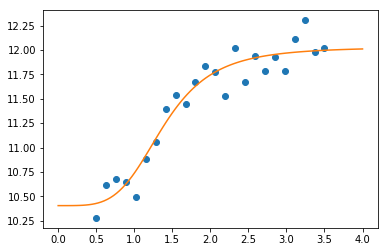

In [13]:
x = np.linspace(0, 4, 100)
y = logistic4(x, *popt)
plt.plot(xdata, ydata, 'o')
plt.plot(x, y)
pass